<a href="https://colab.research.google.com/github/rochmanofenna/BICEP/blob/main/brownian_compute_cpu_v_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!git clone --depth 1 https://github.com/rochmanofenna/mismatch-trading.git
%cd mismatch-trading

#clean any leftover caches
!find . -type d -name '__pycache__' -exec rm -rf {} +

#upgrade pip + wheel
!pip install -q --upgrade pip wheel

#base requirements (no extra deps)
!pip install -q -r requirements/base.txt --no-deps

#cpu only PyTorch so ENN tests pass
!pip uninstall -y torch torchvision torchaudio
!pip install -q torch==2.3.0+cpu torchvision==0.18.0+cpu \
    torchaudio==2.3.0+cpu --extra-index-url https://download.pytorch.org/whl/cpu

#gpu & testing tools
!pip install -q cupy-cuda12x pytest pytest-asyncio matplotlib

Cloning into 'mismatch-trading'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 92 (delta 3), reused 79 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 321.32 KiB | 8.24 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/mismatch-trading/mismatch-trading/mismatch-trading
Found existing installation: torch 2.3.0+cpu
Uninstalling torch-2.3.0+cpu:
  Successfully uninstalled torch-2.3.0+cpu
Found existing installation: torchvision 0.18.0+cpu
Uninstalling torchvision-0.18.0+cpu:
  Successfully uninstalled torchvision-0.18.0+cpu
Found existing installation: torchaudio 2.3.0+cpu
Uninstalling torchaudio-2.3.0+cpu:
  Successfully uninstalled torchaudio-2.3.0+cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torchaudio]


In [14]:
!pytest -q --disable-warnings --maxfail=1

..................................                                       [100%]
34 passed in 4.09s


In [15]:
import os, sys, time, importlib
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

#make sure your package is on the Python path
repo = "/content/mismatch-trading"
if repo not in sys.path:
    sys.path.append(repo)

#bring in bicep brownian motion code
import backends.bicep.brownian_motion as bm

In [16]:
def bench_cpu(T, n_steps, n_paths, batch):
    """Run numpy variant, measure wall-time."""
    os.environ["DISABLE_CUPY"] = "1"
    importlib.reload(bm)
    t0 = time.perf_counter()
    tg, paths = bm.brownian_motion_paths(
        T=T,
        n_steps=n_steps,
        n_paths=n_paths,
        batch=batch
    )
    return time.perf_counter() - t0

def bench_gpu(T, n_steps, n_paths, batch):
    """Run cupy+chunked variant, measure wall-time."""
    os.environ.pop("DISABLE_CUPY", None)
    importlib.reload(bm)
    #GPU timer
    start, end = cp.cuda.Event(), cp.cuda.Event()
    start.record()
    tg, paths = bm.brownian_motion_paths(
        T=T,
        n_steps=n_steps,
        n_paths=n_paths,
        batch=batch
    )
    end.record(); end.synchronize()
    return float(cp.cuda.get_elapsed_time(start, end) * 1e-3)

#sanity check sizes
N_PATHS, N_STEPS, BATCH = 10_000, 5_000, 2_000

cpu_time = bench_cpu(1.0, N_STEPS//5, N_PATHS//5, max(1, BATCH//5))
gpu_time = bench_gpu(1.0, N_STEPS, N_PATHS, BATCH)

print(f"CPU (NumPy) → {cpu_time:.3f}s  shape=({N_PATHS//5},{N_STEPS//5+1})")
print(f"GPU (CuPy)  → {gpu_time:.3f}s  shape=({N_PATHS   },{N_STEPS   +1})")
print(f"Speedup     → {cpu_time/gpu_time:.1f}×")

CPU (NumPy) → 0.077s  shape=(2000,1001)
GPU (CuPy)  → 0.009s  shape=(10000,5001)
Speedup     → 8.5×


In [19]:
#helpers
import os, sys, time, importlib
import numpy as np
import cupy as cp

repo = "/content/mismatch-trading"
if repo not in sys.path:
    sys.path.append(repo)
import backends.bicep.brownian_motion as bm

def bench_cpu(T, n_steps, n_paths, batch):
    os.environ["DISABLE_CUPY"] = "1"
    importlib.reload(bm)
    t0 = time.perf_counter()
    _, _ = bm.brownian_motion_paths(
        T=T, n_steps=n_steps, n_paths=n_paths, batch=batch
    )
    return time.perf_counter() - t0

def bench_gpu_stream(T, n_steps, n_paths, batch):
    os.environ.pop("DISABLE_CUPY", None)
    importlib.reload(bm)

    #memmap host‐side float32
    host = np.memmap("paths.dat", mode="w+",
                     dtype=np.float32, shape=(n_paths, n_steps+1))

    pool = cp.get_default_memory_pool()
    start, end = cp.cuda.Event(), cp.cuda.Event()
    start.record()

    for i in range(0, n_paths, batch):
        sz = min(batch, n_paths - i)
        chunk = bm.simulate_batch(
            T, n_steps, sz, cp,
            dir_bias=0.0, var_adj=None
        ).astype(cp.float32)
        host[i : i+sz, :] = chunk.get()
        pool.free_all_blocks()

    end.record(); end.synchronize()
    return float(cp.cuda.get_elapsed_time(start, end) * 1e-3)


#warm‐up
_ = bench_gpu_stream(1.0, 1_000, 1_000, 100)
_ = bench_cpu(      1.0, 1_000, 1_000, 100)

#sweep
sizes = [5_000, 10_000, 20_000, 50_000]
cpu_times, gpu_times = [], []

for N in sizes:
    batch = max(1, N // 10)

    ct = bench_cpu(1.0, N, N, batch)
    gt = bench_gpu_stream(1.0, N, N, batch)

    cpu_times.append(ct)
    gpu_times.append(gt)
    print(f"N={N:6d}   CPU={ct:6.2f}s   GPU={gt:6.2f}s   Speedup={ct/gt:5.1f}×")

N=  5000   CPU=  0.96s   GPU=  0.12s   Speedup=  8.0×
N= 10000   CPU=  4.06s   GPU=  0.52s   Speedup=  7.8×
N= 20000   CPU= 16.12s   GPU=  3.02s   Speedup=  5.3×
N= 50000   CPU=102.13s   GPU= 28.01s   Speedup=  3.6×


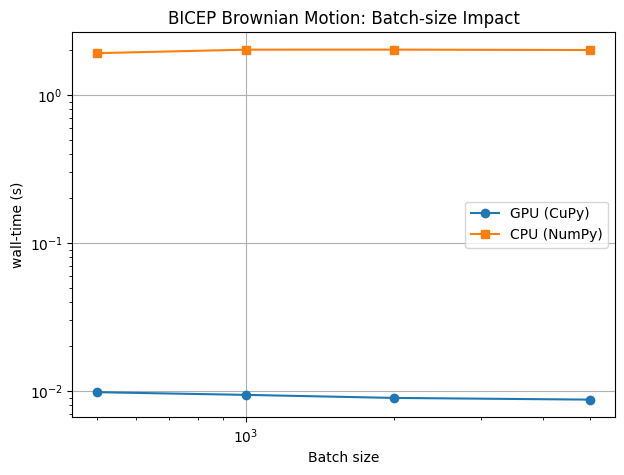

In [20]:
n_paths, n_steps = 10_000, 5_000
batches = [500, 1_000, 2_000, 5_000]

gpu_bt = [bench_gpu(1.0, n_steps, n_paths, b) for b in batches]
cpu_bt = [bench_cpu(1.0, n_steps, n_paths, b) for b in batches]

plt.figure(figsize=(7,5))
plt.plot(batches, gpu_bt, '-o', label='GPU (CuPy)')
plt.plot(batches, cpu_bt, '-s', label='CPU (NumPy)')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Batch size'); plt.ylabel('wall-time (s)')
plt.title('BICEP Brownian Motion: Batch-size Impact')
plt.legend(); plt.grid(True)
plt.show()

In [23]:
import os, sys, time, importlib
import numpy as np
import cupy as cp

#add your repo to the path
repo = "/content/mismatch-trading"
if repo not in sys.path:
    sys.path.append(repo)
import backends.bicep.brownian_motion as bm

def bench_gpu_stream32(T, n_steps, n_paths, batch):
    #make sure CuPy is active
    os.environ.pop("DISABLE_CUPY", None)
    importlib.reload(bm)

    #host memmap for float32
    host = np.memmap(
        "paths.dat", mode="w+",
        dtype=np.float32,
        shape=(n_paths, n_steps + 1)
    )

    #device memory pool
    pool = cp.get_default_memory_pool()
    start_evt, end_evt = cp.cuda.Event(), cp.cuda.Event()
    start_evt.record()

    #precompute sqrt(dt) in float32
    dt32 = np.float32(T / n_steps)
    sqrt_dt = cp.float32(np.sqrt(dt32))

    for i in range(0, n_paths, batch):
        sz = min(batch, n_paths - i)

        #allocate one float32 buffer and fill *in place*
        inc = cp.empty((sz, n_steps), dtype=cp.float32)
        # CuPy’s Generator.normal currently doesn’t support out=,
        # so we do two steps—but both remain float32:
        cp.random.default_rng().standard_normal(
            size=(sz, n_steps),
            dtype=cp.float32,
            out=inc
        )
        #scale in-place
        inc *= sqrt_dt

        #cumsum into a second float32 buffer
        chunk = cp.empty((sz, n_steps + 1), dtype=cp.float32)
        chunk[:, 0] = 0
        cp.cumsum(inc, axis=1, out=chunk[:, 1:])

        #stream back to host
        host[i : i + sz] = chunk.get()

        #free everything before next iteration
        pool.free_all_blocks()

    end_evt.record()
    end_evt.synchronize()

    elapsed = float(cp.cuda.get_elapsed_time(start_evt, end_evt) * 1e-3)
    return elapsed, host

N_PATHS, N_STEPS = 100_000, 150_000

BATCH = 5_000

gpu_time, gpu_paths = bench_gpu_stream32(1.0, N_STEPS, N_PATHS, BATCH)
print(f"GPU stream32 → {gpu_time:.2f}s, shape={gpu_paths.shape}")

GPU stream32 → 176.79s, shape=(100000, 150001)
